# Tensorflow Basics

This notebook is a quick refresher for the Tensorflow basics. 

It is based on the following official guides:
1. [Overview](https://www.tensorflow.org/guide/basics)
2. [Tensors](https://www.tensorflow.org/guide/tensor)
3. [Variables](https://www.tensorflow.org/guide/variable)
4. [Automatic differentiation](https://www.tensorflow.org/guide/autodiff)
5. [Graphs and Functions](https://www.tensorflow.org/guide/intro_to_graphs)
6. [Modules, layers, models](https://www.tensorflow.org/guide/intro_to_modules)
7. [Training Loops](https://www.tensorflow.org/guide/basic_training_loops)

## Basic Setup

In [1]:
import os

# Suppress unwanted TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# Just FIX my local problem with duplicated packages:
os.environ['PATH'] = f'/usr/local/cuda-12.5/bin:{os.environ["PATH"]}'

Import TF and Matplotlib:

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

## Quick Overview

### Tensors

[Tensors](https://www.tensorflow.org/api_docs/python/tf/Tensor) (multi-dimensional arrays) are basic data structures on which all operations are performed:

In [3]:
t = tf.constant([[1, 2, 3], [4, 5, 6]])
print("Value: ", t.numpy().tolist())
print("Shape: ", t.shape)
print("Type:  ", t.dtype.name)
print("Device:", t.device)

Value:  [[1, 2, 3], [4, 5, 6]]
Shape:  (2, 3)
Type:   int32
Device: /job:localhost/replica:0/task:0/device:GPU:0


Tensorflow defines multiple operations with tensors:

In [4]:
t + t

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 2,  4,  6],
       [ 8, 10, 12]], dtype=int32)>

In [5]:
t ** t

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[    1,     4,    27],
       [  256,  3125, 46656]], dtype=int32)>

In [6]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[14, 32],
       [32, 77]], dtype=int32)>

In [7]:
tf.reduce_sum(t).numpy()

21

### GPU Support

You can check if GPU is available and if tensor is actually allocated in GPU memory:

In [8]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [10]:
tf.test.is_built_with_cuda()

True

In [11]:
tf.test.is_built_with_gpu_support()

True

See [tf.config.list_physical_devices](https://tensorflow.org/api_docs/python/tf/config/list_physical_devices) and [tf.test.is_gpu_available](https://www.tensorflow.org/api_docs/python/tf/test/is_gpu_available) docs for more details.

### Variables

[tf.Tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor) objects represent immutable nodes of computational graphs. To store trainable model weights or any other mutable state TensorFlow provides a [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) abstraction. 

In [12]:
v = tf.Variable([[1,2,3], [4,5,6]])
print("Value:", v.numpy().tolist())

Value: [[1, 2, 3], [4, 5, 6]]


In [13]:
print("Device:", v.device)

Device: /job:localhost/replica:0/task:0/device:CPU:0


In [14]:
print("Shape:", v.shape)

Shape: (2, 3)


Variables support the same operations as tensors:

In [15]:
v + v

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 2,  4,  6],
       [ 8, 10, 12]], dtype=int32)>

In [16]:
v ** v

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[    1,     4,    27],
       [  256,  3125, 46656]], dtype=int32)>

In [17]:
v @ tf.transpose(v)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[14, 32],
       [32, 77]], dtype=int32)>

In [18]:
v.assign(v ** t)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=int32, numpy=
array([[    1,     4,    27],
       [  256,  3125, 46656]], dtype=int32)>

### Automatic Differentiation

One of the main aims of ML frameworks like TensorFlow is to privide API for automatic differentiation:

In [19]:
def some_function(x):
    return x**2 - 2 * x + 1

x = tf.Variable(0.0)

some_function(x).numpy()

1.0

In [20]:
with tf.GradientTape() as tape:
    y = some_function(x)

gradient_x = tape.gradient(y, x) # dy/dx

gradient_x.numpy() # Should be -2

-2.0

In [21]:
x.assign(1.0)

with tf.GradientTape() as tape:
    y = some_function(x)

gradient_x = tape.gradient(y, x)
gradient_x.numpy() # Should be 0 now

0.0

See [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) class and [tf.GradientTape.gradient(...)](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient) method docs for more details.

### Graphs and tf.function

When using tensors, variables and applying function, TensorFlow builds a [tfGraph](https://www.tensorflow.org/api_docs/python/tf/Graph) object behind the scene. The Graph object serves several purposes:
1. Represent Lazy computations that should be executed on the GPU
2. Make model specification serializeable and deserializeable
3. Allow automatic gradients calculation

In TFv1 the client code used to build Graphs directly. But TFv2 philosophy is to hide the Graph abstraction and provide native Python operations to build graphs automatically instead. So it is not so easy to directly access graphs built by TensorFlow v2. 


#### Accessing @tf.function Graph

But this is actually possible by accessing concrete implementation built for `@tf.function` functions:

In [30]:
@tf.function
def some_func(x):
    return x**2 - 2*x + 1

v = tf.Variable([1.0, 2.0])
y = some_func(v)

concrete_func = some_func.get_concrete_function(v)
graph = concrete_func.graph

graph

#### Visualizing Graph with TensorBoard

It is also possible to write graph summary to the logs and displaying it with TensorBoard:

In [22]:
from tensorflow import keras
from datetime import datetime

model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

(train_images, train_labels), _ = keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model.fit(
    train_images,
    train_labels,
    batch_size=64,
    epochs=5,
    callbacks=[tensorboard_callback]
)

Epoch 1/5


I0000 00:00:1719494423.310587    4532 service.cc:145] XLA service 0x756570007c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719494423.310609    4532 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6


 40/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3212 - loss: 1.9518  

I0000 00:00:1719494424.413797    4532 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6792 - loss: 0.9385
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.8205 - loss: 0.5096
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.8410 - loss: 0.4476
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.8451 - loss: 0.4303
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.8507 - loss: 0.4170


In [23]:
%load_ext tensorboard

In [24]:
%tensorboard --logdir logs

In [29]:
tf.random.uniform((3,3))

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.01333368, 0.88374174, 0.03898644],
       [0.77957   , 0.04412699, 0.34613442],
       [0.77130115, 0.3601129 , 0.9397435 ]], dtype=float32)>

#### More Comments on Graphs

For function call to build the graph, it should be decorated with [@tf.function](https://www.tensorflow.org/api_docs/python/tf/function) which will compile it into callable TensorFlow Graph upon every call with a new signature. 

The first call to the `tf.function` executes in Python:

In [31]:
def inner_function(x, a, b):
    print("From inner!")
    return a*x + b

@tf.function
def outer_function(x, a, b):
    print("From outer!")
    y = inner_function(x, a, b)
    return y**2 - 2*y + 1

In [33]:
x = tf.random.uniform((3,))
a = tf.random.uniform((3, 3))
b = tf.random.uniform((3,))

In [34]:
outer_function(x, a, b) # Should produce Python side-effects

From outer!
From inner!


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.12316582, 0.21268663, 0.00938499],
       [0.31938896, 0.2760742 , 0.02978361],
       [0.32496268, 0.2783684 , 0.4771428 ]], dtype=float32)>

In [35]:
outer_function(x, a, b) # The second call shouldn't produce any side-effects

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.12316582, 0.21268663, 0.00938499],
       [0.31938896, 0.2760742 , 0.02978361],
       [0.32496268, 0.2783684 , 0.4771428 ]], dtype=float32)>

**NOTE**: On subsequent calls TensorFlow only executes the optimized graph, skipping any non-TensorFlow steps. But upon a call with a new signature it should recompile again! 

In [40]:
# Should produce side effects as we are calling with different shapes:
outer_function(tf.constant([3]), tf.constant(2), tf.constant(1)) 

From outer!
From inner!


<tf.Tensor: shape=(1,), dtype=int32, numpy=array([36], dtype=int32)>

### Models, Layers and Models

[tf.Module](https://www.tensorflow.org/api_docs/python/tf/Module) is a base high-level API class for managing NeuralNetworks and other models as a whole. 

### Training Loops


#### Obtain Data

In [116]:
actual_a, actual_b = 1.5, 2.0

def actual_function(x):
    """Actual function to be reconstructed."""
    return actual_a*x + actual_b

def noise(x, mean=0.0, stddev=1.0):
    """Generate noise."""
    return tf.random.normal(x.shape, mean=mean, stddev=stddev, dtype=x.dtype)

x = tf.linspace(-10, 10, 100)
y = actual_function(x) + noise(x, stddev=2.0)

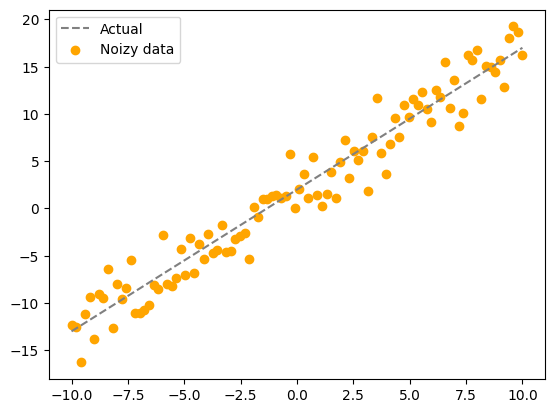

In [117]:
plt.plot(x, actual_function(x), '--', label='Actual', c='grey')
plt.scatter(x, y, label='Noizy data', c='orange')
plt.legend()

#### Define Model

In [118]:
class MyModel(tf.Module):
    def __init__(self, dtype, **kwargs):
        super().__init__(**kwargs)
        self.a = tf.Variable(0.0, dtype=dtype)
        self.b = tf.Variable(0.0, dtype=dtype)

    def __call__(self, x):
        return self.a * x + self.b

#### Define Loss

In [119]:
def loss(target_y, predicted_y):
    """Calculate loss."""
    return tf.reduce_mean(tf.square(target_y - predicted_y))

#### Define a Training Loop

In [120]:
from dataclasses import dataclass, field
from typing import List

@dataclass(frozen=True)
class Report:
    a: List[float] = field(default_factory=list)
    b: List[float] = field(default_factory=list)
    loss: List[float] = field(default_factory=list)

def train(model, x, y, learning_rate, loss=loss):
    """Execute one learning step."""
    with tf.GradientTape() as tape:
        current_loss = loss(y, model(x))

    da, db = tape.gradient(current_loss, [model.a, model.b])
    model.a.assign_sub(learning_rate * da)
    model.b.assign_sub(learning_rate * db)
    return current_loss

In [121]:
def training_loop(model, x, y, n_epochs: int=10, learning_rate:float=0.1)->Report:
    """Actual training loop."""
    report = Report()
    for epoch in range(n_epochs):
        report.a.append(model.a.numpy())
        report.b.append(model.b.numpy())
        loss = train(model, x, y, learning_rate)
        report.loss.append(loss)
    return report

#### Create and Train Model

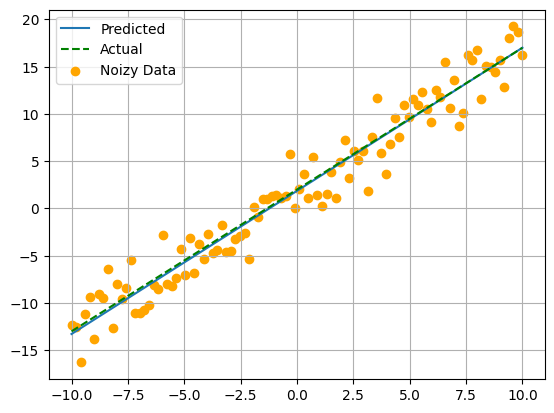

In [134]:
model = MyModel(dtype=y.dtype)
n_epochs = 400
report = training_loop(model, x, y, learning_rate=0.01, n_epochs=n_epochs)
plt.plot(x, model(x), label="Predicted")
plt.plot(x, actual_function(x), '--', c='green', label="Actual")
plt.scatter(x, y, c='orange', label="Noizy Data")
plt.grid()
plt.legend()

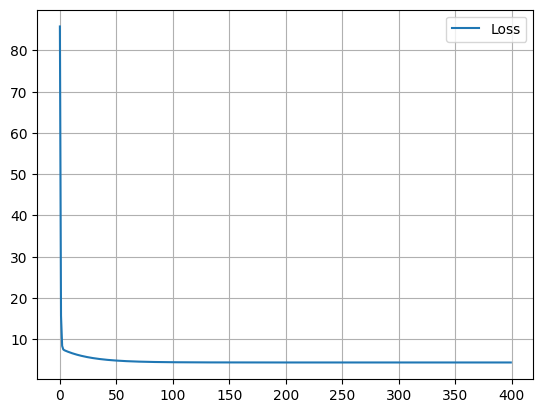

In [135]:
plt.plot(range(n_epochs), report.loss, label="Loss")
plt.grid()
plt.legend()

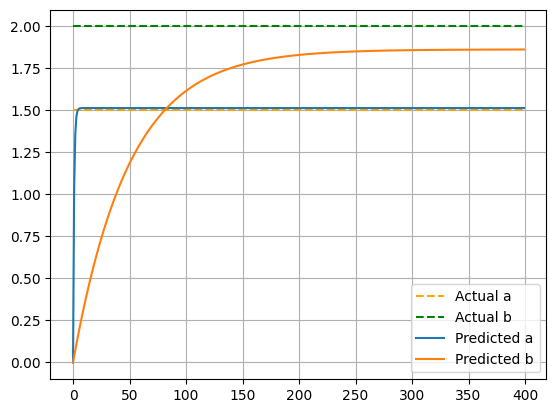

In [136]:
plt.plot(range(n_epochs), [actual_a]*n_epochs, '--', c='orange', label="Actual a")
plt.plot(range(n_epochs), [actual_b]*n_epochs, '--', c='green', label="Actual b")
plt.plot(range(n_epochs), report.a, label="Predicted a")
plt.plot(range(n_epochs), report.b, label="Predicted b")
plt.grid()
plt.legend()